In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Plots
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (12,5)

In [2]:
class Track:

    def __init__(
            self,
            name,
            num_curves,
            distance_curves,
            radio_curves,
            distance_straights,
            ):
        
        self.name = name
        self.num_curves = num_curves
        self.distance_curves = distance_curves
        self.radio_curves = radio_curves
        self.distance_straights = distance_straights

        self.distance = np.sum(distance_curves) + np.sum(distance_straights)


    def is_curve(self, pos):

        # Get real pos
        pos = pos % self.distance

        find_pos = self.distance_straights[0]
        c_idx = 0

        for c,s in zip(self.distance_curves, self.distance_straights[1:]):
            if pos <= find_pos:
                return False, 0

            find_pos += c

            if pos <= find_pos:
                return True, c_idx
            
            c_idx += 1
            find_pos += s

        return False, 0


    def get_curve_max_speed(self, car, curve_idx):
        coeff = 0.1
        return coeff * self.distance_curves[curve_idx] * self.radio_curves[curve_idx] * car.grip

In [3]:
class Car:

    def __init__(
            self,
            name,
            hp,
            grip,
    ):
        self.delta_t = 0.0001
        
        self.name = name
        self.hp = hp
        self.grip = grip
        self.velocity = [(self.hp/10)*self.grip*math.log(a) for a in np.arange(1, 100, self.delta_t)]

        self.max_speed = max(self.velocity)

    def get_acc_speed(self, idx):
        if idx < len(self.velocity):
            return self.velocity[idx] * self.grip**(1/3)
        else:
            return self.velocity[-1] * self.grip**(1/3)

In [4]:
high_speed_ring_params = {
    'name': 'High Speed Raceway',
    'distance': 100,
    'num_curves': 6,
    'distance_curves': [30*2, 40*2, 20*2, 15*2, 35*2, 25*2],
    'radio_curves': [2, 1, 2, 2, 1, 2],
    'distance_straights': [200, 150, 100, 50, 50, 100, 100],
}

high_speed_ring = Track(
    high_speed_ring_params['name'],
    high_speed_ring_params['num_curves'],
    high_speed_ring_params['distance_curves'],
    high_speed_ring_params['radio_curves'],
    high_speed_ring_params['distance_straights'],
    )



In [5]:
car_params = {
    'name': 'test',
    'hp': 100,
    'grip': 1,
}

test_car = Car(
    car_params['name'],
    car_params['hp'],
    car_params['grip'],
)

for i in range(len(high_speed_ring.distance_curves)):
    print(f"{high_speed_ring.get_curve_max_speed(test_car, i):.2f}")

12.00
8.00
8.00
6.00
7.00
10.00


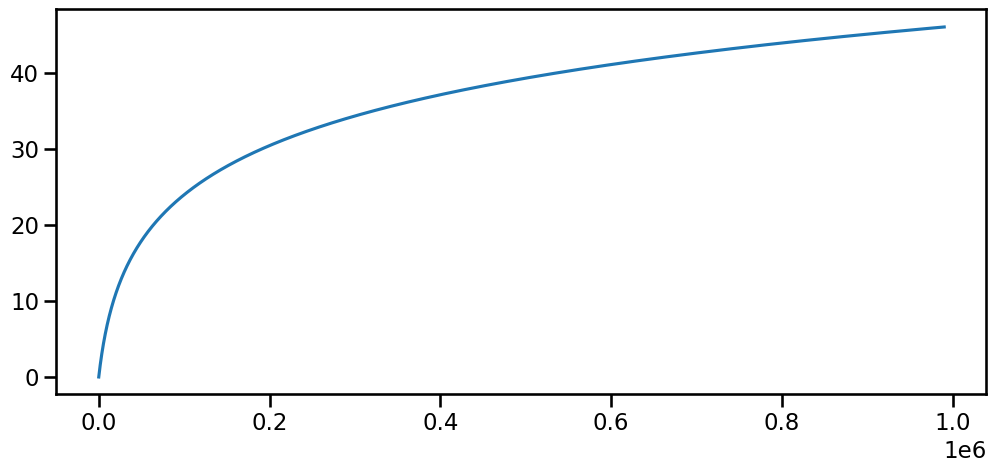

In [6]:
plt.plot(test_car.velocity)
plt.show()

In [7]:
eps = 1e-8 # Should be car property
test_car.grip = 1

# Randomness
rnd_level = 30
rnd_prob = 0.5
rnd_max_speed = 1

num_laps = 4

car_pos = 0
car_vel_idx = 0
time = 0

all_speeds = []
all_distances = []
all_times = []

speed = []
distance = []

laps = 0


while laps < num_laps:

    # DEGRADATION
    test_car.grip *= (1-eps)

    time += test_car.delta_t
    speed.append(test_car.get_acc_speed(car_vel_idx))

    # Is straigh
    #print(car_pos)
    is_curve, curve_idx = high_speed_ring.is_curve(car_pos)
    #print(f"IS CURVE: {is_curve}")



    if not is_curve:
        car_vel_idx += 1
        if np.random.random() < rnd_prob and test_car.get_acc_speed(car_vel_idx) > 5:
            car_vel_idx += np.random.randint(-rnd_level, rnd_level)
    else:
        # TODO: This was hardcoded as a test
        max_speed = high_speed_ring.get_curve_max_speed(test_car, curve_idx)
        #print(f"CURVE MAX SPEED: {max_speed}")

        if test_car.get_acc_speed(car_vel_idx+1) > max_speed:
            # Brake is faster than accelerate
            speed_frac = test_car.get_acc_speed(car_vel_idx) / test_car.max_speed
            car_vel_idx = max( car_vel_idx - int(10*(speed_frac)), 1)
        else:
            if np.random.random() < 0.5:
                car_vel_idx += 1

    # Get velocity
    #print("Velocity:", test_car.velocity[car_vel_idx])

    # Get delta distance
    delta_dist = test_car.delta_t * (test_car.get_acc_speed(car_vel_idx-1) + test_car.get_acc_speed(car_vel_idx))/2
    car_pos += delta_dist

    distance.append(car_pos)


    if car_pos > high_speed_ring.distance:
        laps += 1
        car_pos = car_pos % high_speed_ring.distance
        
        print(f"LAP TIME: {time:.3f}")
        all_times.append(time)

        all_distances.append(distance)
        all_speeds.append(speed)

        time = 0
        speed = []
        distance = []



LAP TIME: 80.094
LAP TIME: 76.444
LAP TIME: 76.059
LAP TIME: 76.984


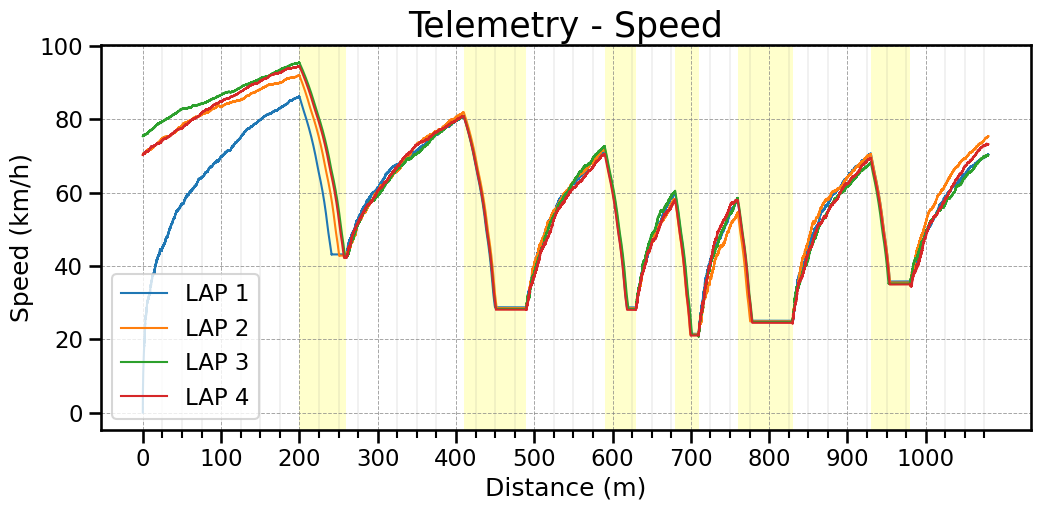

In [8]:
speed_km = [[3.6*s for s in ls] for ls in all_speeds]

for idx, sp in enumerate(speed_km):
    plt.plot(all_distances[idx], sp, label=f'LAP {idx+1}', linewidth=1.5)

# Fill Curves
d_i = high_speed_ring.distance_straights[0]
d_f = high_speed_ring.distance_straights[0]

for c,s in zip(high_speed_ring.distance_curves, high_speed_ring.distance_straights[1:]):

    d_f += c
    plt.axvspan(d_i, d_f, color='yellow', alpha=0.2, lw=0)

    d_f += s
    d_i = d_f


# Set Ticks
major_xticks = np.arange(0, max(all_distances[0]), 100)
minor_xticks = np.arange(0, max(all_distances[0]), 25)

plt.xticks(major_xticks)
plt.xticks(minor_xticks, minor=True)

plt.xlabel("Distance (m)")
plt.ylabel("Speed (km/h)")

plt.title("Telemetry - Speed", fontsize=25)

plt.grid(which='minor', linestyle="-", color='grey', alpha=0.5, linewidth = 0.3)
plt.grid(which='major', linestyle="--", color='grey', alpha=0.7, linewidth = 0.7)

plt.legend()

plt.show()

GT-Racing 2023